In [4]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

In [5]:
# Define symbolic variables
a, x, y, h, C, D, nu, qo = sp.symbols('a x y h C D nu qo', real=True)
Nlim = 30
wND = []

for N in range(1, Nlim+1):
    print(f"N = {N}")
    
    # Material properties
    D_val = 1
    qo_val = 1
    a_val = 1
    D11, D22 = D_val, D_val
    D12 = nu * D_val
    D66 = (1 - nu) * D_val / 2
    
    sRatio = 1  # Aspect ratio
    yo = a_val / 2
    ap = a_val
    bp = ap * sRatio
    
    # Basis functions
    X = [(x/ap)**ii for ii in range(1, N+1)]
    Y = [(y/bp)*jj - (y/bp)*(jj+1) for jj in range(1, N+1)]
    
    CCoeffs = sp.MatrixSymbol('C', N, N)
    qCoeffs = sp.MatrixSymbol('qc', N, N)
    q = 0
    qMat = sp.zeros(N, N)
    
    for n in range(1, N+1):
        for m in range(1, N+1):
            alpha_m = m * sp.pi / ap
            beta_n = n * sp.pi / bp
            q += qCoeffs[m-1, n-1] * sp.sin(alpha_m*x) * sp.sin(beta_n*y)
            qMat[m-1, n-1] = qCoeffs[m-1, n-1] * sp.sin(alpha_m*x) * sp.sin(beta_n*y)
    
    qCoeffsSol = sp.zeros(N, N)
    for n in range(1, N+1):
        for m in range(1, N+1):
            if m % 2 == 1:
                qCoeffsSol[m-1, n-1] = 8 * qo_val / (sp.pi * bp * m) * sp.sin(n * sp.pi * yo / bp)
    
    q0 = q.subs({qCoeffs[i, j]: qCoeffsSol[i, j] for i in range(N) for j in range(N)})
    q0mat = qMat.subs({qCoeffs[i, j]: qCoeffsSol[i, j] for i in range(N) for j in range(N)})
    
    wo = sum(X[ii] * Y[jj] * CCoeffs[ii, jj] for ii in range(N) for jj in range(N))
    
    Kernel = (D11 * sp.diff(wo, x, x)*2 + D22 * sp.diff(wo, y, y)*2 
              + 2 * D12 * sp.diff(wo, y, y) * sp.diff(wo, x, x) 
              + 4 * D66 * sp.diff(wo, x, y)**2)
    
    U = 1/2 * sp.integrate(sp.integrate(Kernel, (x, 0, ap)), (y, 0, bp))
    V = -sp.integrate(sp.integrate(q0 * wo, (x, 0, ap)), (y, 0, bp))
    Energy = U + V
    
    Eq = sp.Matrix(N, N, lambda i, j: sp.diff(Energy, CCoeffs[i, j]))
    Eq = Eq.reshape(N*N, 1)
    CCoeffs_flat = sp.Matrix(N*N, 1, lambda i, j: CCoeffs[i//N, i%N])
    Csol = sp.solve(Eq, CCoeffs_flat)
    
    wsol = wo.subs({CCoeffs[i, j]: Csol[CCoeffs[i, j]] for i in range(N) for j in range(N)})
    wND.append(wsol.subs({qo: 1, a: 1, D: 1, nu: 0.3, x: 1, y: 1/2}))


N = 1
N = 2


KeyError: C[0, 1]

ValueError: x and y must have same first dimension, but have shapes (30,) and (1,)

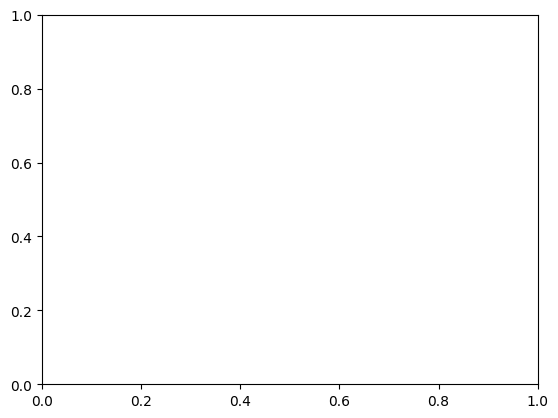

In [6]:
# Convergence Plot
plt.figure()
plt.plot(range(1, Nlim+1), [float(w) for w in wND], linewidth=2)
plt.xlabel('N terms')
plt.ylabel('w_{ND}')
plt.title('SSSF Plate - Convergence Plot (RR)')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

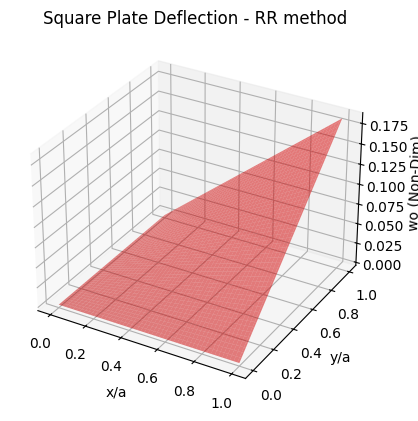

In [7]:
# Surface Plot
xvec = np.linspace(0, 1, 100)
yvec = np.linspace(0, 1, 100)
X, Y = np.meshgrid(xvec, yvec)
wsol_numeric = wsol.subs({qo: 1, a: 1, D: 1, nu: 0.3})
wS = sp.lambdify((x, y), wsol_numeric, 'numpy')
wSS = wS(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, wSS, color='r', alpha=0.5)
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
ax.set_zlabel('wo (Non-Dim)')
ax.set_title('Square Plate Deflection - RR method')
plt.show
